In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import json
import wandb

from src.net import InstanceGCN
from src.dataset import MultiTargetDataset
from src.utils import normalize_curve, compute_integral

In [3]:
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim/')

T = 120
all_shortnames = {'_'.join(fp.name.split('_')[:2]) for fp in results_dir.glob(f'*_{T}_*.json')}
all_shortnames
for shortname in all_shortnames:
    print(shortname)
    print(len(list(results_dir.glob(shortname+f'_{T}_*.json'))))

ws_-1
60
ws_500
60
ef_200
60
tr_-1
60
ef_1000
60
ws_1000
60
ws_200
60
tr_500
60
tr_200
60
ef_500
60
bs_0
60
tr_1000
60


In [4]:
def load_all_results(shortname: str):
    results = list()
    for result_fpath in results_dir.glob(shortname+f'_{T}_*.json'):
        size = int(result_fpath.name.split('_')[3])
        size_id = int(result_fpath.name.split('_')[4][:-len('.json')])

        with open(result_fpath) as f:
            result = json.load(f)

        solution_fpath = opts_dir/f"{T}_{size}_{size_id}_opt.npz"
        solution_npz = np.load(solution_fpath)
        quasi_optimal_objective = solution_npz['arr_0'].astype('uint32')

        results.append(dict(
            size=size,
            size_id=size_id,
            opt_obj=quasi_optimal_objective,
            **result
        ))
    df = pd.DataFrame(results)
    df['primal_curve'] = df['primal_curve'].apply(normalize_curve)
    df['primal_curve'] = df['primal_curve'] / df['opt_obj']

    return df

dfs = {shortname: load_all_results(shortname) for shortname in all_shortnames}
dfs['bs_0']

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve
0,24,63,13172,False,120.002369,13104.0,0.070629,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,22,67,11183,False,120.004859,10769.0,0.101321,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,20,60,11127,False,120.000587,11083.0,0.021797,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,20,73,9907,False,120.000310,9100.0,0.190612,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,24,68,14699,False,120.000376,13656.0,0.183236,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,20,78,9713,False,120.004597,9303.0,0.136832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,24,79,13422,False,120.002371,12435.0,0.259526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,22,68,14417,False,120.000499,14099.0,0.120519,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,22,64,13000,False,120.000524,12546.0,0.207742,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,20,71,15763,False,120.000436,14969.0,0.238018,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
infeasibilities = list()
sns = list()
for sn in dfs.keys():
    df = dfs[sn]
    infeasibility = df['infeasible'].sum() / df.shape[0]

    sns.append(sn)
    infeasibilities.append(infeasibility)

pd.Series(infeasibilities, index=sns, name='infeasibility rate').sort_index()

bs_0       0.033333
ef_1000    0.266667
ef_200     0.033333
ef_500     0.100000
tr_-1      1.000000
tr_1000    0.016667
tr_200     0.000000
tr_500     0.033333
ws_-1      0.016667
ws_1000    0.000000
ws_200     0.033333
ws_500     0.033333
Name: infeasibility rate, dtype: float64

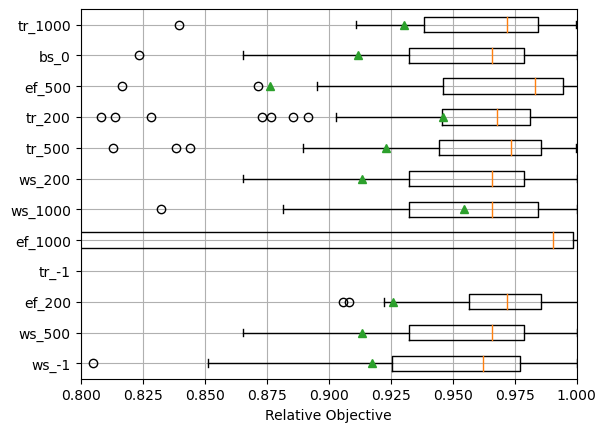

In [6]:
rel_objs = list()
sns = list()
for sn, df in dfs.items():
    rel_objs.append((df['objective'] / df['opt_obj']).values)
    sns.append(sn)
    # (df['objective'] / df['opt_obj']).plot.box(showmeans=True)
plt.boxplot(rel_objs, labels=sns, vert=False, showmeans=True)
plt.xlim(0.8,1)
plt.xlabel('Relative Objective')
plt.grid()
plt.show()

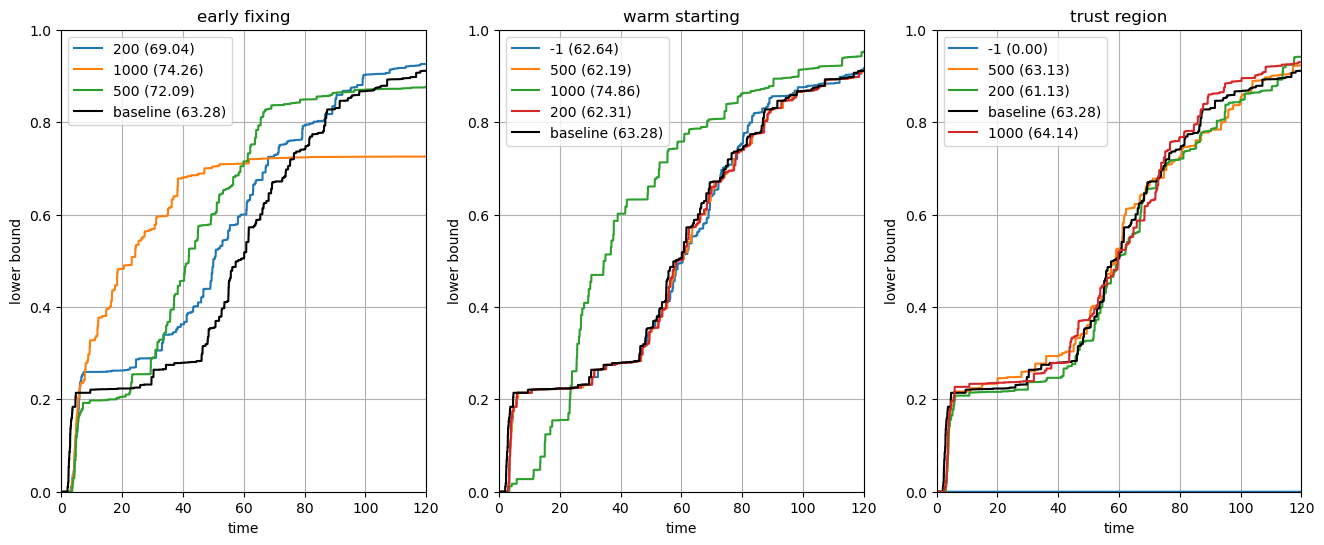

In [7]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

fig, axs = plt.subplots(1,3)

fig.set_size_inches(16,6)

axs[0].set_title('early fixing')
axs[1].set_title('warm starting')
axs[2].set_title('trust region')

for sn, df in dfs.items():
    dt = 1e-3
    curve = df['primal_curve'].mean()
    auc = np.sum(curve * dt)
    x = np.arange(len(curve)) * dt
    if sn.startswith('ef'):
        ax = axs[0]
    elif sn.startswith('ws'):
        ax = axs[1]
    elif sn.startswith('tr'):
        ax = axs[2]
    else:
        for ax in axs:
            ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
        continue
    ax.plot(x, curve, label=sn[3:]+f" ({auc:.2f})")
    ax.set_ylabel('lower bound')
    ax.set_xlabel('time')
# plt.plot(df[~df['infeasible']]['primal_curve'].mean())

for ax in axs:
    ax.set_xlim(0,120)
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid()
plt.show()

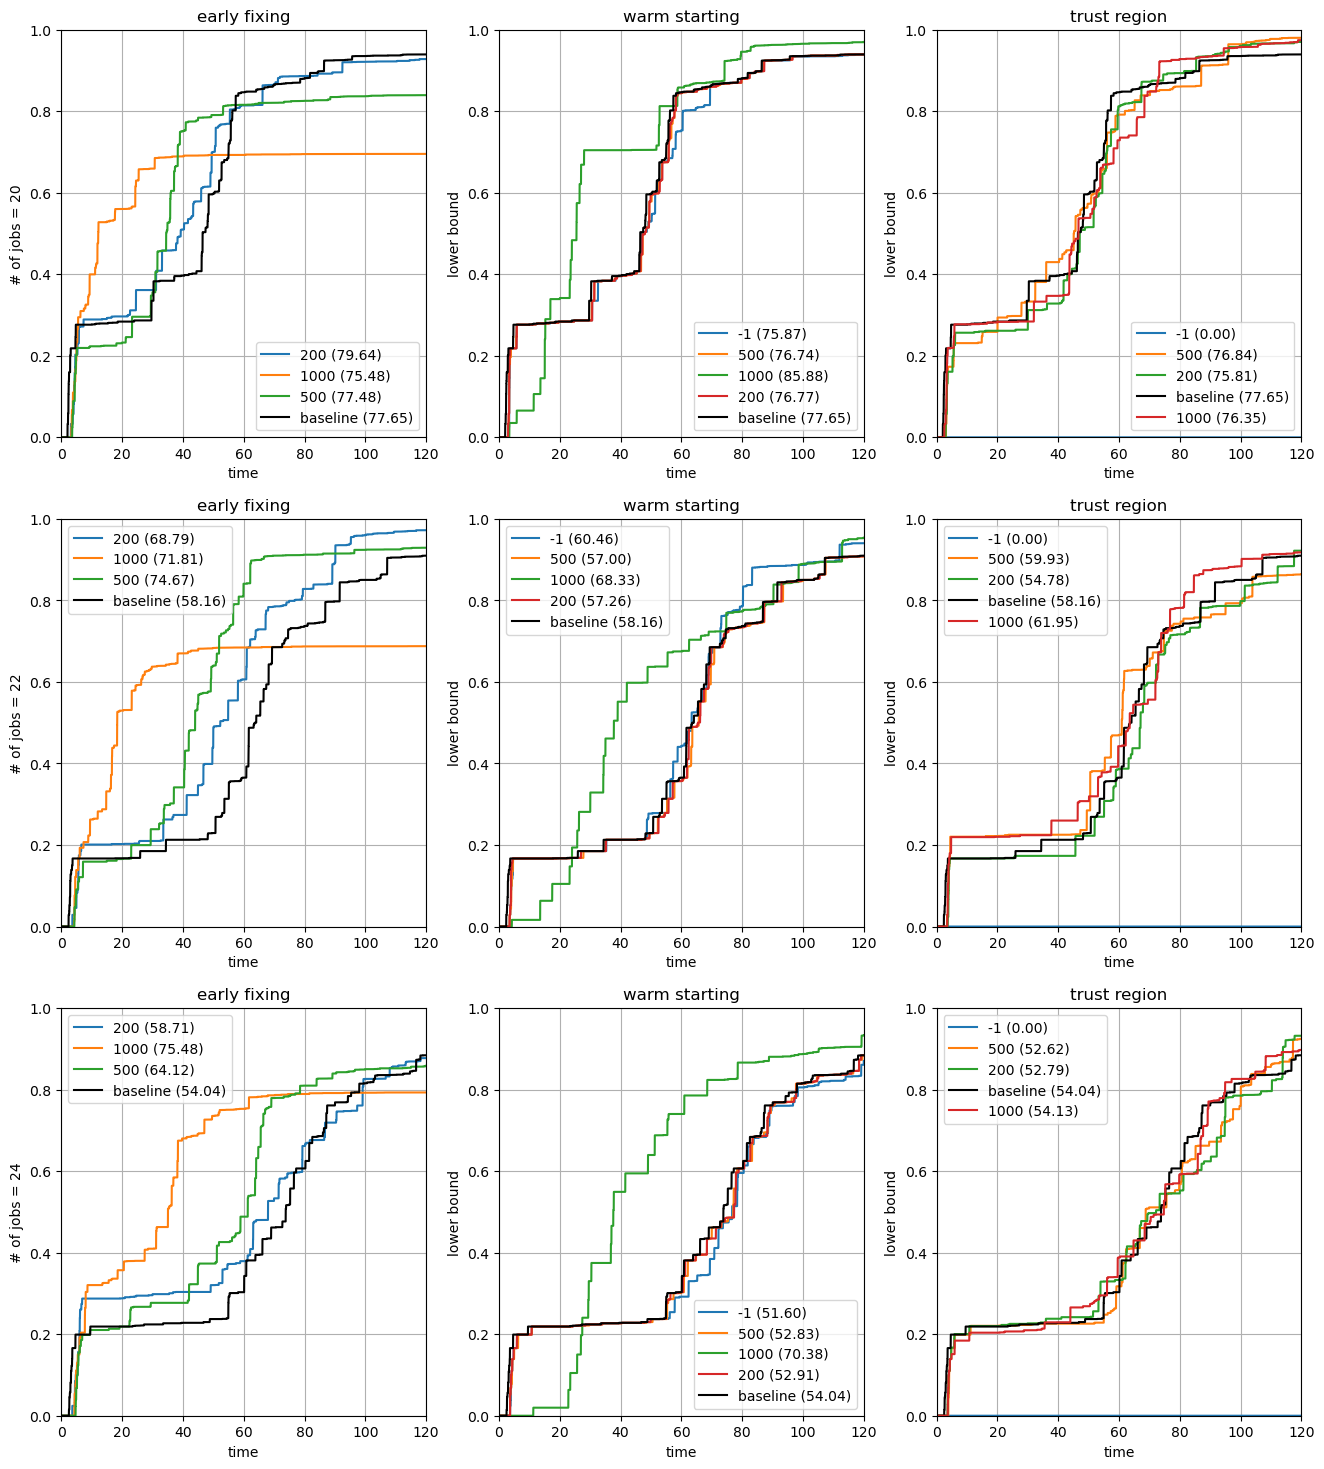

In [8]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

sizes = sorted(dfs['bs_0']['size'].unique())

fig, axss = plt.subplots(len(sizes),3)

fig.set_size_inches(16,len(sizes) * 6)

for i, s in enumerate(sizes):
    axs = axss[i]

    axs[0].set_title('early fixing')
    axs[1].set_title('warm starting')
    axs[2].set_title('trust region')

    for sn, df_ in dfs.items():
        df = df_[df_['size'] == s]

        dt = 1e-3
        curve = df['primal_curve'].mean()
        auc = np.sum(curve * dt)
        x = np.arange(len(curve)) * dt

        if sn.startswith('ef'):
            ax = axs[0]
        elif sn.startswith('ws'):
            ax = axs[1]
        elif sn.startswith('tr'):
            ax = axs[2]
        else:
            for ax in axs:
                ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
            continue
        ax.plot(x, curve, label=sn[3:]+f" ({auc:.2f})")
        ax.set_ylabel('lower bound')
        ax.set_xlabel('time')
    # plt.plot(df[~df['infeasible']]['primal_curve'].mean())

    for ax in axs:
        ax.set_xlim(0,120)
        ax.set_ylim(0,1)
        ax.legend()
        ax.grid()

    axs[0].set_ylabel(f'# of jobs = {s}')
plt.show()